In [ ]:
import numpy as np
from scipy import ndimage
from skimage import color, io
import time
import matplotlib.pyplot as plt
import skimage.measure as measure
import queue
%matplotlib inline

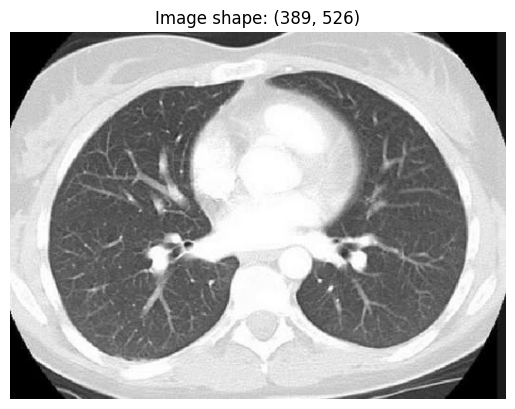

In [ ]:
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))

image  = normalize(color.rgb2gray(io.imread('CT_lungs.jpg')))
plt.figure()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image shape: " + str(image.shape))
plt.show()

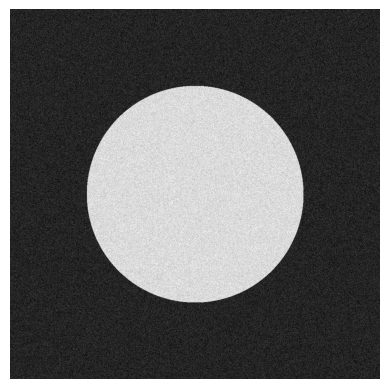

In [ ]:
def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

y_size = 1024
x_size = 1024
circle = generate_circle(y_size, x_size, 512, 512, 300)
circle = circle + (np.random.random((y_size, x_size))-0.5)*0.4
circle = normalize(circle)

plt.figure()
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def image_threshold(image, lower, upper):
  image_tresholded = np.zeros(image.shape)
  nrows, ncols = image.shape
  for i in range(nrows):
    for j in range(ncols):
      if image[i,j] >= lower and image[i,j] <= upper:
        image_tresholded[i,j] = 1
  return image_tresholded

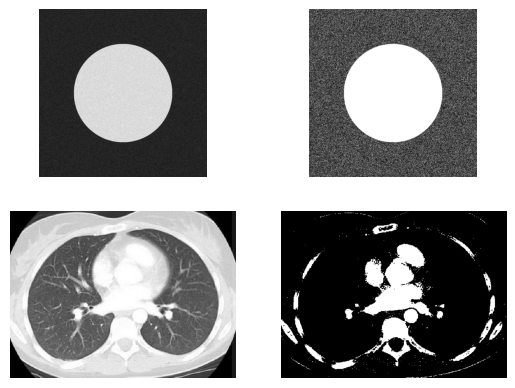

In [ ]:
circle_thresholded = image_threshold(circle, 0.2, 1)
image_thresholded = image_threshold(image, 0.95, 1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_thresholded, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_thresholded, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
'''
label return Labeled array, where all connected regions are assigned the same integer value

1-connectivity     2-connectivity     diagonal connection close-up

     [ ]           [ ]  [ ]  [ ]             [ ]
      |               \  |  /                 |  <- hop 2
[ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
      |               /  |  \             hop 1
     [ ]           [ ]  [ ]  [ ]
'''
def region_growing_global(image, seed, bottom_threshold, upper_threshold, connectivity=2):
    segmentation_result = np.zeros(image.shape)

    seed_value = image[seed]
    min_val = seed_value - bottom_threshold
    max_val = seed_value + upper_threshold

    mask = (image >= min_val) & (image <= max_val)

    labeled = measure.label(mask, connectivity=connectivity)

    seed_label = labeled[seed]

    segmentation_result[labeled == seed_label] = 1

    return segmentation_result

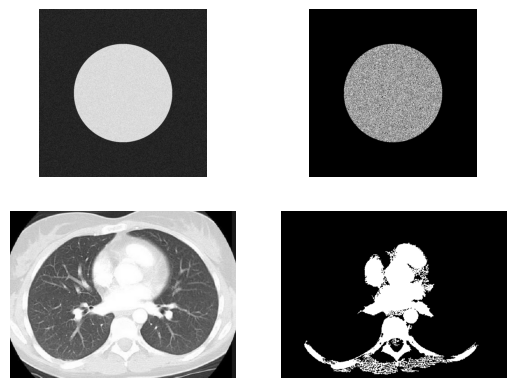

In [ ]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_global = region_growing_global(circle, get_center(circle),  0.1, 0.1)
image_region_global = region_growing_global(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_region_global, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_region_global, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def region_growing_local(image, seed, bottom_threshold, upper_threshold):
    seed_value = image[seed]
    min_val = seed_value - bottom_threshold
    max_val = seed_value + upper_threshold

    pixel_queue = queue.Queue()
    visited = set()

    def get_neighbours(coordinate):
        neighbours = []

        for dy in [-1, 0, 1]:
          for dx in [-1, 0, 1]:
            if dx == 0 and dy == 0:
              continue
            neighbour = (coordinate[0] + dy, coordinate[1] + dx)
            if 0 <= neighbour[0]  < image.shape[0] and 0 <= neighbour[1] < image.shape[1]:
              neighbours.append(neighbour)
        return neighbours

    segmentation_image = np.full(np.shape(image), False)
    pixel_queue.put(seed)

    while not pixel_queue.empty():
        current = pixel_queue.get()
        current_val = image[current]
        if current_val >= min_val and current_val <= max_val:
            segmentation_image[current] = True
            for neighbor in get_neighbours(current):
              if neighbor not in visited:
                pixel_queue.put(neighbor)
                visited.add(neighbor)

    return segmentation_image

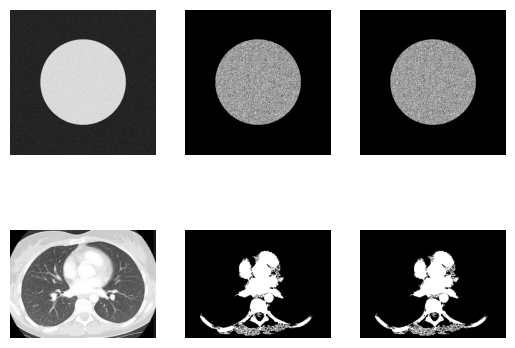

In [ ]:
get_center = lambda image: (int(image.shape[0] / 2) - 1, int(image.shape[1] / 2) - 1)
circle_region_local = region_growing_local(circle, get_center(circle),  0.1, 0.1)
image_region_local = region_growing_local(image, get_center(image), 0.1, 0.1)
circle_region_local_2 = region_growing_local(circle, get_center(circle),  0.1, 0.1)
image_region_local_2 = region_growing_local(image, get_center(image), 0.1, 0.1)

plt.figure()
plt.subplot(2, 3, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(circle_region_local, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(circle_region_local_2, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(image_region_local, cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(image_region_local_2, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
y_size, x_size = 2048, 2048
values = [16, 32, 64, 128, 256]
times = []
for value in values:
    current_circle = generate_circle(y_size, x_size, 1024, 1024, value)
    b_t = time.time()
    _ = region_growing_local(current_circle, get_center(current_circle), 0.1, 0.1)
    e_t = time.time()
    print("Time for local version, radius: ", value, ": ", e_t - b_t)
    b_t = time.time()
    _ = region_growing_global(current_circle, get_center(current_circle), 0.1, 0.1)
    e_t = time.time()
    print("Time for global version, radius: ", value, ": ", e_t - b_t)

Time for local version, radius:  16 :  0.008460521697998047
Time for global version, radius:  16 :  0.046311378479003906
Time for local version, radius:  32 :  0.0686333179473877
Time for global version, radius:  32 :  0.07523226737976074
Time for local version, radius:  64 :  0.19574356079101562
Time for global version, radius:  64 :  0.05708432197570801
Time for local version, radius:  128 :  0.5078845024108887
Time for global version, radius:  128 :  0.0393218994140625
Time for local version, radius:  256 :  1.7188913822174072
Time for global version, radius:  256 :  0.045239925384521484
